<a href="https://colab.research.google.com/github/pop756/IonQ-Skku/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/IonQ-Skku/
!pip install -r requirements.txt


Mounted at /content/drive
/content/drive/MyDrive/IonQ-Skku
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.2 MB/s eta 0:00:00


In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, CXGate
from qiskit.circuit import Parameter, ParameterVector, Barrier
from qiskit.circuit import Gate
from qiskit_algorithms.minimum_eigensolvers.vqe import VQE
from qiskit.primitives import StatevectorEstimator as Estimator
import numpy as np
from qiskit_algorithms.optimizers import COBYLA




In [7]:
optimizer = COBYLA()

In [68]:
num_q_orbital=2
num_q_site=16

qc_total=QuantumCircuit(num_q_orbital+num_q_site)

qc_orbital=QuantumCircuit(num_q_orbital) # orbital register

qc_site=QuantumCircuit(num_q_site) # site register
qc_p=QuantumCircuit(num_q_site) # minimum unit for representing quantum number p
qc_QFT=QuantumCircuit(num_q_site) # quantum circuit for executing quantum fourier transform

In [74]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp  # Assuming you are using Qiskit's SparsePauliOp








######################
# Hamiltonian mapping
######################

class CalculateT:
    def __init__(self, orbital_energy, hopping_energy):
        self.orbital_energy = orbital_energy
        self.hopping_energy = hopping_energy

    @property
    def t_aa_0(self):
        return -self.orbital_energy

    @property
    def t_bb_0(self):
        return self.orbital_energy

    @property
    def t_ab_0(self):
        return 0

    @property
    def t_ba_0(self):
        return 0

    @property
    def t_aa_1(self):
        return 0

    @property
    def t_bb_1(self):
        return 0

    @property
    def t_ab_1(self):
        return 0

    @property
    def t_ba_1(self):
        return 0

def list_to_str(list_data):
    return ''.join(map(str, list_data))


class Hamiltonian(CalculateT):
    def __init__(self, num_q_orbital, num_q_site, orbital_energy, hopping_energy):
        self.num_q_orbital = num_q_orbital
        self.num_q_site = num_q_site
        super().__init__(orbital_energy, hopping_energy)

    def _A_onsite(self, hoping_number):
        result = None
        t_aa = getattr(self, f't_aa_{hoping_number}') / 2
        t_bb = getattr(self, f't_bb_{hoping_number}') / 2

        for i in range(self.num_q_orbital):
            identity = ['I'] * self.num_q_orbital
            Z_factor = identity.copy()
            Z_factor[i] = 'Z'

            identity_str = list_to_str(identity)
            Z_factor_str = list_to_str(Z_factor)

            if result is None:
                result = SparsePauliOp([identity_str, Z_factor_str], coeffs=[t_aa, -t_aa])
            else:
                result += SparsePauliOp([identity_str, Z_factor_str], coeffs=[t_bb, -t_bb])

        return result

    def _A_hop(self, hoping_number):
        result = None
        t_ab = getattr(self, f't_ab_{hoping_number}') / 4
        t_ba = getattr(self, f't_ba_{hoping_number}') / 4
        t = t_ab + t_ba

        for i in range(self.num_q_orbital):
            identity = ['I'] * self.num_q_orbital
            X_factor = identity.copy()
            Y_factor = identity.copy()
            X_factor[i] = 'X'
            Y_factor[i] = 'Y'

            for j in range(i + 1, self.num_q_orbital):
                X_factor[j] = 'X'
                Y_factor[j] = 'Y'
                X_factor_str = list_to_str(X_factor)
                Y_factor_str = list_to_str(Y_factor)

                if result is None:
                    result = SparsePauliOp([X_factor_str, Y_factor_str], coeffs=[t, t])
                else:
                    result += SparsePauliOp([X_factor_str, Y_factor_str], coeffs=[t, t])

        return result

    def _B_hop(self):
        result = None
        t_ab = getattr(self, 't_ab_1') / 4
        t_ba = getattr(self, 't_ba_1') / 4
        t = t_ba - t_ab

        for i in range(self.num_q_orbital):
            identity = ['I'] * self.num_q_orbital
            X_factor = identity.copy()
            Y_factor = identity.copy()
            X_factor[i] = 'Y'
            Y_factor[i] = 'X'

            for j in range(i + 1, self.num_q_orbital):
                X_factor[j] = 'X'
                Y_factor[j] = 'Y'
                X_factor_str = list_to_str(X_factor)
                Y_factor_str = list_to_str(Y_factor)

                if result is None:
                    result = SparsePauliOp([X_factor_str, Y_factor_str], coeffs=[t, -t])
                else:
                    result += SparsePauliOp([X_factor_str, Y_factor_str], coeffs=[t, -t])

        return result

    @property
    def A_0(self):
        result = self._A_onsite(0) + self._A_hop(0)
        return result

    @property
    def A_1(self):
        result = self._A_onsite(1) + self._A_hop(1)
        return result

    @property
    def B_1(self):
        result = self._B_hop()
        return result

    def hamiltonian(self, p):
        coeff = 2 * np.pi * p / self.num_q_site
        return (self.A_0 + 2 * (self.A_1 * np.cos(coeff)) - self.B_1 * np.sin(coeff)).simplify()


In [75]:

onsite_energy = 1.0
hopping_energy = 1


ham = Hamiltonian(num_q_orbital, num_q_site, onsite_energy , hopping_energy)
hamiltonian = ham.hamiltonian

In [76]:
from qiskit.quantum_info import SparsePauliOp

def list_to_str(list_data):
    str_first = ''
    for str_data in list_data:
        str_first += str_data
    return str_first

########### 여기 줄 잘 바꾸샘
def custom_hamiltonian(qubit_number):
    list_data = []
    for i in range(qubit_number):
        raw_data = ['I']*qubit_number
        raw_data[i] = 'Z'
        data = list_to_str(raw_data)
        list_data.append(data)



    return SparsePauliOp(list_data,coeffs=[0.1*i for i in range(qubit_number)])

In [77]:
def A(theta, phi):
    qc_ansatze_unit=QuantumCircuit(2, name="A") # minimum unit of the number preserving ansatze ; included into the qc_orbital
    qc_ansatze_unit.cx(0,1)
    qc_ansatze_unit.rz(phi+np.pi, 0).inverse()
    qc_ansatze_unit.ry(theta+np.pi/2, 0).inverse()
    qc_ansatze_unit.cx(1,0)
    qc_ansatze_unit.ry(theta+np.pi/2, 0)
    qc_ansatze_unit.rz(phi+np.pi, 0)
    qc_ansatze_unit.cx(0,1)
    return qc_ansatze_unit

def ansatze_orbital_encoding(energy_level):
    qc_ansatze_o_ecdg=QuantumCircuit(num_q_orbital)
    qc_ansatze_o_ecdg.x(energy_level)
    return qc_ansatze_o_ecdg

def ansatze_level(energy_level, params_level):
    qc_ansatze_E_level=QuantumCircuit(num_q_orbital, name='level_'+str(energy_level))
    for i in range(num_q_orbital-energy_level-1):
        inst=A(theta=params_level[2*i], phi=params_level[2*i+1]).to_instruction()
        qc_ansatze_E_level.append(inst, [i+energy_level, i+energy_level+1])
    return qc_ansatze_E_level




def vqe(energy_level, previous_params_list,p):
    if previous_params_list==None: # target energy level is 0th : ground state band
        qc_orbital_0th=ansatze_orbital_encoding(energy_level) # orbital encoding for 0th energy level

        # addition of 0th level ansatze
        num_params=2*(num_q_orbital-energy_level-1)
        params_0th=ParameterVector("θ", num_params)
        qc_orbital_tmp=ansatze_level(energy_level, params_level=params_0th)
        inst=qc_orbital_tmp.to_instruction()
        qc_orbital_0th.append(inst, range(num_q_orbital))
        def loss(x):
            estimator = Estimator()
            pub = (qc_orbital_0th,hamiltonian(p),x)
            job = estimator.run([pub])
            result = job.result()[0]
            return np.sum(result.data.evs)

        result = optimizer.minimize(loss,x0 = [0.2]*qc_orbital_0th.num_parameters)
        print(f'1st eigen energy information : {result}')
        params_fixed_0th = result.x # further obtained
        res = result.fun
        return res, params_fixed_0th
    else: # set ansatze for nonzero energy level
        qc_orbital_ith=ansatze_orbital_encoding(energy_level)

        # current energy level
        num_params=2*(num_q_orbital-energy_level-1)
        params=ParameterVector("θ", num_params)
        qc_orbital_tmp=ansatze_level(energy_level, params_level=params)
        inst_current=qc_orbital_tmp.to_instruction()
        qc_orbital_ith.append(inst_current, range(num_q_orbital))

        # previous energy level with fixed parameters
        for i in reversed(range(energy_level)):
            qc_orbital_ith.barrier()

            params=previous_params_list[i]
            previous_level_qc=ansatze_level(energy_level=i, params_level=params)
            inst=previous_level_qc.to_instruction()
            qc_orbital_ith.append(inst, range(num_q_orbital))

        def loss(x):
            estimator = Estimator()
            pub = (qc_orbital_ith,hamiltonian(p),x)
            job = estimator.run([pub])
            result = job.result()[0]
            return np.sum(result.data.evs)

        result = optimizer.minimize(loss,x0 = [0.2]*qc_orbital_ith.num_parameters)
        print(f'{energy_level+1}th eigen energy information : {result}')
        params_fixed_ith=result.x # further obtained
        res = result.fun
        return res, params_fixed_ith


upper_bound_level=1
params_library = dict()
res_list = {}
res_list['0'] = []
res_list['1'] = []

for p in range(num_q_site):
  print(f'p={p}')
  for i in range(upper_bound_level+1):

      if i==0:
          res , params_fixed_0th = vqe(energy_level=i, previous_params_list=None,p=p)
          try:
              params_library['level'+str(i)].append(params_fixed_0th)
          except:
              params_library['level'+str(i)] = []
              params_library['level'+str(i)].append(params_fixed_0th)
          res_list['0'].append(res)
      else:
          params_send = [params_library['level'+str(j)][p] for j in range(i)]
          res , params_fixed_ith = vqe(energy_level=i, previous_params_list=params_send,p=p)
          try:
              params_library['level'+str(i)].append(params_fixed_ith)
          except:
              params_library['level'+str(i)] = []
          res_list['1'].append(res)

p=0
1st eigen energy information : {   'fun': -0.9999999956349654,
    'jac': None,
    'nfev': 37,
    'nit': None,
    'njev': None,
    'x': array([1.57074961, 0.54960937])}
2th eigen energy information : {   'fun': 0.9999999956349654,
    'jac': None,
    'nfev': 1,
    'nit': None,
    'njev': None,
    'x': array([], dtype=float64)}
p=1
1st eigen energy information : {   'fun': -0.9999999956349654,
    'jac': None,
    'nfev': 37,
    'nit': None,
    'njev': None,
    'x': array([1.57074961, 0.54960937])}
2th eigen energy information : {   'fun': 0.9999999956349654,
    'jac': None,
    'nfev': 1,
    'nit': None,
    'njev': None,
    'x': array([], dtype=float64)}
p=2
1st eigen energy information : {   'fun': -0.9999999956349654,
    'jac': None,
    'nfev': 37,
    'nit': None,
    'njev': None,
    'x': array([1.57074961, 0.54960937])}
2th eigen energy information : {   'fun': 0.9999999956349654,
    'jac': None,
    'nfev': 1,
    'nit': None,
    'njev': None,
    'x': arr

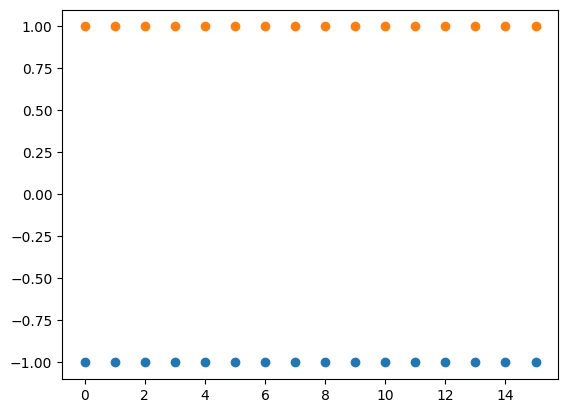

In [78]:
from matplotlib import pyplot as plt
plt.plot(res_list['0'][int(num_q_site/2):]+res_list['0'][:int(num_q_site/2)], 'o',label='0th level')
plt.plot(res_list['1'][int(num_q_site/2):]+res_list['1'][:int(num_q_site/2)], 'o',label='1st level')